In [1]:
# Es una buena idea asegurarse de que estés utilizando la última versión de las bibliotecas que necesitas.
# !pip install -Uqq <bibliotecas> actualiza a la última versión de <bibliotecas>
# Nota: Puedes ignorar de manera segura cualquier advertencia o error que pip muestre acerca de ejecutarse como root o incompatibilidades"
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai numpy

**Importante: Activa los aceleradores GPU T4 x2 en los tres puntos al lado del estado de tu sesión. Esto te permitirá entrenar este modelo mucho más rápido**
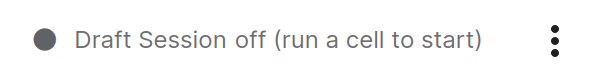

# Paso 0. Importar las librerias
Importamos la librería para visión por computadora de fastai

In [2]:
from fastai.vision.all import *

# Paso 1. Preparación de los Datos
Para este proyecto usamos el dataset **skin-cancer-malingnant-vs-benign**. Para poder acceder al dataset, utilizaremos:
- **data_path**: Path al dataset
- **train_path**: Path a los datos de entrenamiento
- **test_path**: Path a los datos de testeo

In [3]:
data_path = Path('/kaggle/input/skin-cancer-malignant-vs-benign')
train_path = data_path / 'train'
test_path = data_path / 'test'

# Paso 2. Creación del modelo
Creamos un modelo de DeepLearning para la clasificación de imágenes utilizando la biblioteca fastai. Creamos un **DataBlock** para cargar el dataset y, posteriormente, utilizando su atributo **dataloaders** cargamos el dataset de entrenamiento (**train_path**).

Los componentes clave de un DataBlock son:
- bloques (tipos de Entrada y Salida)
- getters (función para obtener datos)
- splitter (función para dividir datos en conjuntos de entrenamiento y validación)
- item_tfms (transformaciones a nivel de ítem)
- batch_tfms (transformaciones a nivel de lote)


In [4]:
data_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=10),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
)

In [6]:
data_loaders = data_block.dataloaders(train_path, bs=32)
# bs es batch_size: el número de ejemplos que se introducen en la red neuronal cada vez que entrena.
# Si el número es pequeño, significa que la red tiene en memoria poca cantidad de datos, y entrena más rápido.

## Paso 2.1. Visualización
Siempre es una buena práctica visualizar que tu modelo haya cargado los datos de manera correcta, usando el atributo **show_batch**.




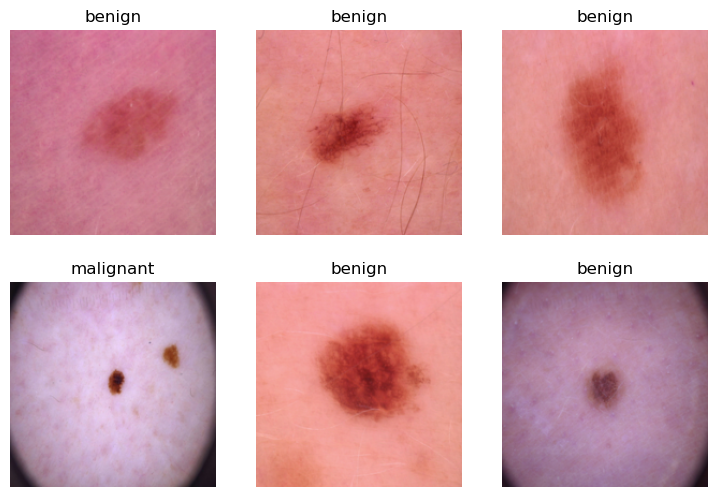

In [7]:
data_loaders.show_batch(max_n=6)

# Paso 3. Entrenamiento del Modelo
Ahora que sabemos que el dataset carga bien, podemos crear nuestro modelo de aprendizaje profundo para la clasificación de imágenes. Escogemos una arquitectura preentrenada adecuada, **ResNet34**, y utilizamos la transferencia de aprendizaje para ajustar el modelo al conjunto de datos.

Usamos **vision_learner** y luego el atributo **fine_tune**

In [8]:
learn = vision_learner(data_loaders, resnet34, metrics=accuracy)
learn.fine_tune(9) # El número representa la cantidad de ciclos de entrenamiento, "epochs".

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,0.741985,0.405956,0.846300,00:35


epoch,train_loss,valid_loss,accuracy,time
0,0.538467,0.343799,0.865275,00:21
1,0.303767,0.265240,0.901328,00:20
2,0.258657,0.413136,0.886148,00:20
3,0.177854,0.304390,0.878558,00:20
4,0.099259,0.326420,0.908918,00:20
5,0.057548,0.329626,0.907021,00:20
6,0.028472,0.310176,0.903226,00:20
7,0.016988,0.294370,0.912713,00:20
8,0.008285,0.295833,0.918406,00:20


In [12]:
# La siguiente línea guardará tu modelo ya entrenado
learn.save('skin_cancer_model')

# Las siguientes líneas cargarán tu modelo ya entrenado
# path_to_model = "path/to/your/trained/model.pkl"
# model = load_learner(path_to_model)

Path('models/skin_cancer_model.pth')

# Paso 4. Predicciones
Ahora que ya poseemos un modelo entrenado, podemos ver qué tan bien generaliza con nueva información utilizando nuestro test set. 

In [9]:
import numpy as np

# Crea un test data loader utilizando nuestro path al test set
test_files = get_image_files(test_path)
test_dl = learn.dls.test_dl(test_files)

# Obtiene las predicciones y las etiquetas verdaderas de las imágenes
preds, _, decoded_preds = learn.get_preds(dl=test_dl, with_decoded=True)
ground_truth = np.array([0 if parent_label(file) == 'benign' else 1 for file in test_files])

# Calculamos la precisión de las predicciones
accuracy = np.mean(decoded_preds.numpy() == ground_truth)
print(f"Test set accuracy: {accuracy*100:.2f}%")

Test set accuracy: 88.64%


# Final
Si la precisión del modelo su durante entrenamiento es muy similar a la precisión del modelo utilizando el test set, ¡felicidades! Eso significa que el modelo ha aprendido a identificar los patrones que identifican al cáncer de la piel.